<a href="https://colab.research.google.com/github/curiosity806/2020_dacon_satellite_precipitation/blob/bogyung/Dacon_satellite_outlier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import random
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Conv2DTranspose, MaxPooling2D, BatchNormalization, Activation, concatenate, Input, GlobalAveragePooling2D
from tensorflow.keras import Model
import warnings
import gc
 
warnings.filterwarnings("ignore")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
tf.__version__

'2.2.0-rc4'

## 데이터 받아오기

In [0]:
# 훈련 데이터 및 자가 test데이터 불러오기
train = np.load('/content/drive/My Drive/2020 Kaggle Study/data/yeonung/train_real.npy').astype(np.float16)
#test = np.load('/content/drive/My Drive/2020 Kaggle Study/data/32bits_data/test_32bits.npy')

In [6]:
train.shape

(76345, 40, 40, 15)

In [0]:
# 재생산성을 위해 시드 고정
np.random.seed(7)
random.seed(7)
tf.random.set_seed(7)

## 이상치 처리

In [0]:
train[:,:,:,-1].reshape(-1)[train[:,:,:,-1].reshape(-1) < 0] = 0

In [0]:
# 이상치 최대값으로 치환

train[:,:,:,2].reshape(-1)[train[:,:,:,2].reshape(-1)>500] = 500
train[:,:,:,3].reshape(-1)[train[:,:,:,3].reshape(-1)>500] = 500
train[:,:,:,5].reshape(-1)[train[:,:,:,5].reshape(-1)>350] = 350
train[:,:,:,6].reshape(-1)[train[:,:,:,6].reshape(-1)>350] = 350

In [0]:
# Robust Scaler

from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
train_scaled = scaler.fit_transform(train.reshape(-1, 1))
train_scaled = train_scaled.reshape(train.shape)
train_scaled[:,:,:,9] = train[:,:,:,9]//100
train_scaled[:,:,:,-1] = train[:,:,:,-1]

## 모델만들기

In [0]:
def build_model(input_layer, start_neurons):
    
    # 40 x 40 -> 20 x 20
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(input_layer)
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(conv1)
    pool1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D((2, 2))(pool1)
    pool1 = Dropout(0.25)(pool1)

    # 20 x 20 -> 10 x 10
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(pool1)
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(conv2)
    pool2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D((2, 2))(pool2)
    pool2 = Dropout(0.25)(pool2)

    # 10 x 10 
    convm = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(pool2)

    # 10 x 10 -> 20 x 20
    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv2 = concatenate([deconv2, conv2])
    uconv2 = Dropout(0.25)(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)
    uconv2 = BatchNormalization()(uconv2)

    # 20 x 20 -> 40 x 40
    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    uconv1 = Dropout(0.25)(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
    uconv1 = BatchNormalization()(uconv1)
    uconv1 = Dropout(0.25)(uconv1)
    output_layer = Conv2D(1, (1,1), padding="same", activation='relu')(uconv1)
    
    return output_layer

input_layer = Input((40, 40, 10))
output_layer = build_model(input_layer, 32)

In [0]:
model = Model(input_layer, output_layer)

In [0]:
from sklearn.metrics import f1_score

def mae(y_true, y_pred) :
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    y_true = y_true.reshape(1, -1)[0]
    y_pred = y_pred.reshape(1, -1)[0]
    over_threshold = y_true >= 0.1
    return np.mean(np.abs(y_true[over_threshold] - y_pred[over_threshold]))

def fscore(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    y_true = y_true.reshape(1, -1)[0]
    y_pred = y_pred.reshape(1, -1)[0]
    remove_NAs = y_true >= 0
    y_true = np.where(y_true[remove_NAs] >= 0.1, 1, 0)
    y_pred = np.where(y_pred[remove_NAs] >= 0.1, 1, 0)
    return(f1_score(y_true, y_pred))

def maeOverFscore(y_true, y_pred):
    return mae(y_true, y_pred) / (fscore(y_true, y_pred) + 1e-07)

def fscore_keras(y_true, y_pred):
    score = tf.py_function(func=fscore, inp=[y_true, y_pred], Tout=tf.float32, name='fscore_keras')
    return score

def maeOverFscore_keras(y_true, y_pred):
    score = tf.py_function(func=maeOverFscore, inp=[y_true, y_pred], Tout=tf.float32,  name='custom_mse') 
    return score

In [0]:
model.compile(loss="mae", optimizer="adam", metrics=[maeOverFscore_keras, fscore_keras])

## 데이터 제네레이터 만들기

In [15]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5)
model_history = []
fold_number = 0

for train_index, test_index in kf.split(train_scaled):
    print(f'\nFold {fold_number}')
    fold_number = fold_number + 1
    
#-----------------------------------------------------------------------------
    def trainGenerator():
        for file in train_scaled[train_index]:
            target= file[:,:,-1].reshape(40,40,1)
            cutoff_labels = np.where(target < 0, 0, target)
            feature = file[:,:,:10]#########################land type 추가
            if (cutoff_labels > 0).sum() < 50:
                continue
            yield (feature, cutoff_labels)
    train_dataset = tf.data.Dataset.from_generator(trainGenerator,
                                                (tf.float32, tf.float32),
                                                (tf.TensorShape([40,40,10]),########################land type 추가
                                                    tf.TensorShape([40,40,1])))
    train_dataset = train_dataset.batch(512).prefetch(1)
#-----------------------------------------------------------------------------
    def testGenerator():
        for file in train_scaled[test_index]:
            target= file[:,:,-1].reshape(40,40,1)
            cutoff_labels = np.where(target < 0, 0, target)
            feature = file[:,:,:10]#########################land type 추가
            if (cutoff_labels > 0).sum() < 50:
                continue
            yield (feature, cutoff_labels)
    test_dataset = tf.data.Dataset.from_generator(testGenerator,
                                                (tf.float32, tf.float32),
                                                (tf.TensorShape([40,40,10]),########################land type 추가
                                                    tf.TensorShape([40,40,1])))
    test_size = len(test_index)
    test_dataset = test_dataset.batch(test_size).prefetch(1)
#-----------------------------------------------------------------------------

    
    
    history = model.fit(train_dataset, epochs = 10, verbose=1, validation_data = test_dataset)

    #history = model.fit(train_dataset, epochs = 5, ,batch_size = 11, verbose=1)
    model_history.append(history)
    #del data
    del train_dataset
    del test_dataset
    gc.collect()


Fold 0
Epoch 1/10
50/50 [==============================] - 45s 903ms/step - loss: 0.3682 - maeOverFscore_keras: 4.7186 - fscore_keras: 0.4361 - val_loss: 0.2875 - val_maeOverFscore_keras: 4.0218 - val_fscore_keras: 0.4561
Epoch 2/10
50/50 [==============================] - 42s 848ms/step - loss: 0.2965 - maeOverFscore_keras: 3.3941 - fscore_keras: 0.5402 - val_loss: 0.2830 - val_maeOverFscore_keras: 3.1977 - val_fscore_keras: 0.5593
Epoch 3/10
50/50 [==============================] - 42s 842ms/step - loss: 0.2848 - maeOverFscore_keras: 2.9868 - fscore_keras: 0.5875 - val_loss: 0.2730 - val_maeOverFscore_keras: 2.8907 - val_fscore_keras: 0.5944
Epoch 4/10
50/50 [==============================] - 42s 845ms/step - loss: 0.2766 - maeOverFscore_keras: 2.7786 - fscore_keras: 0.6128 - val_loss: 0.2783 - val_maeOverFscore_keras: 3.3163 - val_fscore_keras: 0.5378
Epoch 5/10
50/50 [==============================] - 43s 852ms/step - loss: 0.2714 - maeOverFscore_keras: 2.6455 - fscore_keras: 0.63

KeyboardInterrupt: ignored

In [0]:
# train_300
np.mean([2.3396, 2.2647, 2.1136, 1.8652, 2.0459])

In [0]:
# train
np.mean([1.9441, 2.2429, 2.1413, 2.0706, 2.0027])

2.0803200000000004

In [0]:
# train_del
np.mean([2.3396, 2.2647, 2.1136, 1.8652, 2.0459])

2.1258

In [0]:
## 모델 저장하기
model.save('model_landtype.h5')
!cp model_landtype.h5 '/content/drive/My Drive/2020 Kaggle Study/model'

In [0]:
def plot_acc(his, epoch, title):
    plt.style.use('ggplot')
    plt.figure()
    plt.plot(np.arange(0, epoch), his.history['maeOverFscore_keras'], label='maeOverFscore_keras')
    plt.plot(np.arange(0, epoch), his.history['val_maeOverFscore_keras'], label='val_maeOverFscore_keras')
    plt.title(title)
    plt.xlabel(f'Epoch {epoch}')
    plt.ylabel('Accuracy')
    plt.legend(loc='upper right')
    plt.show()

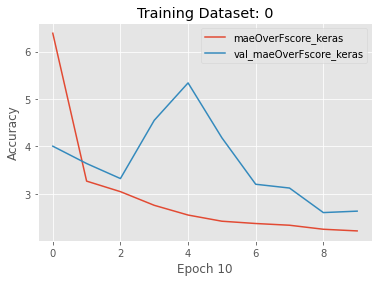

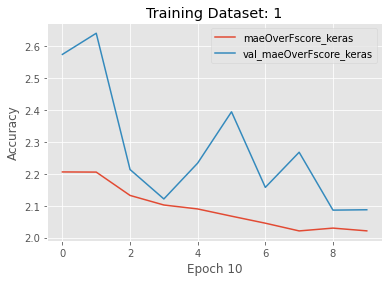

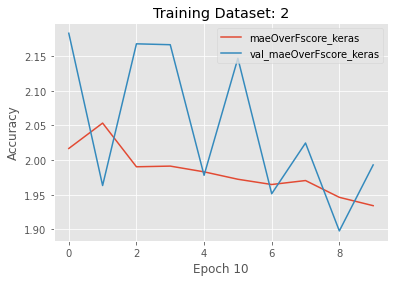

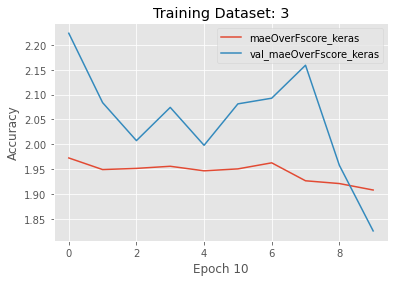

In [0]:
for dataset in range(4):
    #plot_loss(model_history[dataset], 10 , f'Training Dataset: {dataset}')
    plot_acc(model_history[dataset], 10 , f'Training Dataset: {dataset}')


## submission 만들기

In [0]:
# 훈련에서 사용하는 0~8번 채널, ladtype 만을 뽑아서 X_test에 저장하기
test_submit = np.load('/content/drive/My Drive/2020 Kaggle Study/data/test.npy')
test_submit = test_submit[:,:,:,:10]
del test_submit
gc.collect()
pred = model.predict(test_submit)

## submission 만들기

In [0]:
submission = pd.read_csv('/content/drive/My Drive/2020 Kaggle Study/data/sample_submission.csv')

In [0]:
submission.iloc[:,1:] = pred.reshape(-1, 1600)

In [0]:
submission.to_csv('Dacon_landtype.csv', index = False)

In [0]:
# 제출파일 구글 드라이브에 올리기
!cp Dacon_landtype.csv '/content/drive/My Drive/2020 Kaggle Study/submission'